# Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow.keras.models import clone_model
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading Preprocessed Data:



In [ ]:
df = pd.read_csv('/content/bitcoin_dataset.csv')
df

,btc_transaction_fees,btc_trade_volume,btc_market_cap,btc_blocks_size,btc_n_transactions_per_block,btc_n_orphaned_blocks,btc_miners_revenue,target
0,57.877857,0.311140,1.945940,1,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1,0
3,2.247564,5.600044,0.362663,1,1,0,1,0
4,44.190936,0.566486,2.222767,1,1,0,1,0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1,1,0,0,0
999996,19.872726,2.683904,2.778303,1,1,0,0,0
999997,2.914857,1.472687,0.218075,1,1,0,1,0
999998,4.258729,0.242023,0.475822,1,0,0,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   btc_transaction_fees          1000000 non-null  float64
 1   btc_trade_volume              1000000 non-null  float64
 2   btc_market_cap                1000000 non-null  float64
 3   btc_blocks_size               1000000 non-null  int64  
 4   btc_n_transactions_per_block  1000000 non-null  int64  
 5   btc_n_orphaned_blocks         1000000 non-null  int64  
 6   btc_miners_revenue            1000000 non-null  int64  
 7   target                        1000000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 61.0 MB


### Shape of Dataset

In [ ]:
print(f"Columns: {df.shape[1]}\nSamples: {df.shape[0]}")

Columns: 8
Samples: 1000000


### Checking for Null Values

In [ ]:
any(df.isna().sum() > 0)

False

### Basic Statistics

In [ ]:
df.describe()

,btc_transaction_fees,btc_trade_volume,btc_market_cap,btc_blocks_size,btc_n_transactions_per_block,btc_n_orphaned_blocks,btc_miners_revenue,target
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723670,11851.104560,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
cat_feats = [x for x in df.columns if len(df[x].unique()) <=2]
num_feats = [x for x in df.columns if x not in cat_feats]

# Exploratory Data Analysis

In [ ]:
df['target'].value_counts()

,count
target,
0,912597
1,87403


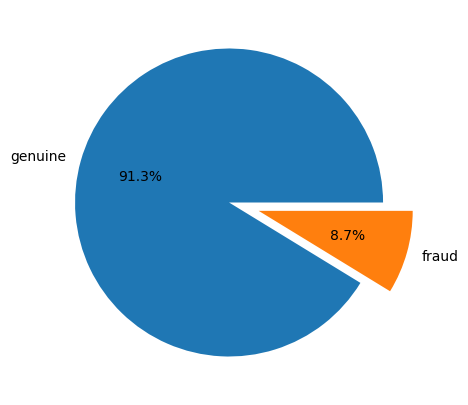

In [ ]:
vc = df['target'].value_counts(ascending=False)
plt.figure(figsize=(5,5))
plt.pie(x=vc.values, labels=['genuine','fraud'], explode=[0.0, 0.2], autopct='%1.1f%%')
plt.show()

### Inferences
* The dataset is heavily **imbalanced**
* The autoencoders only require instances of `genuine` samples for training
* The `fraud` samples will be used for testing

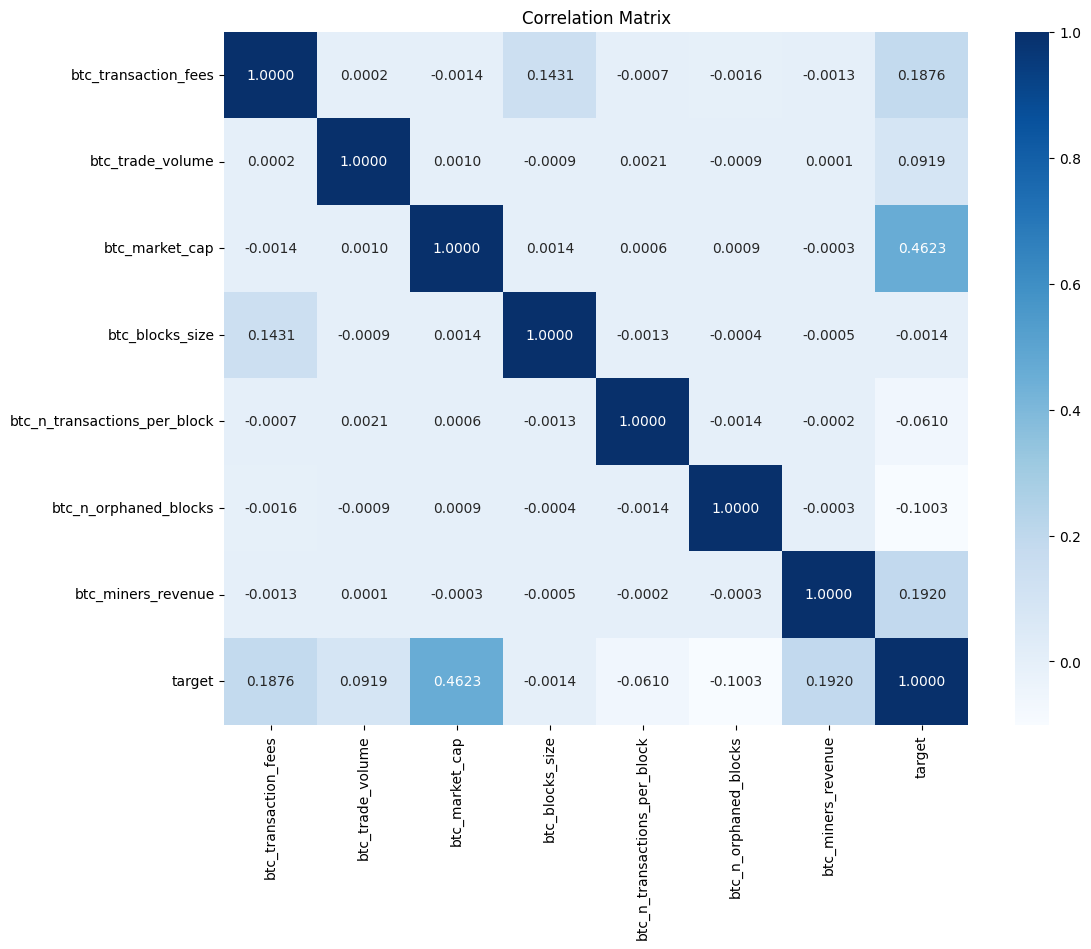

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt='.4f', cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

### Inferences
* Most correlation values are very close to 0, which indicates that our features are **weakly correlated**
* PCA assumes linearity in the data, and it does not work well with Non-linear features
* This is where **Autoencoders** prove to be useful, since they can capture the complex relationships in the data

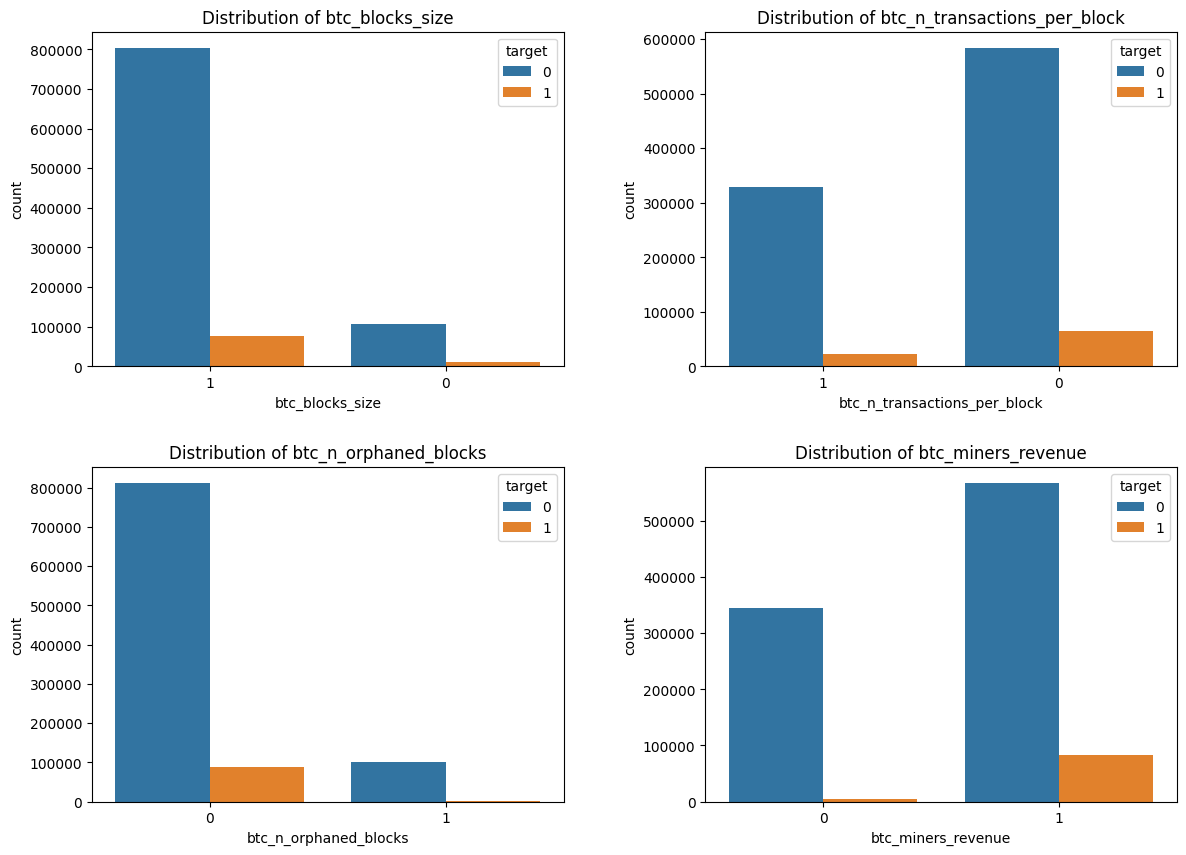

In [ ]:
feats_to_plot = df.columns[3:-1]
plt.figure(figsize=(14,10))
for i, col in enumerate(feats_to_plot):
    plt.subplot(2,2,i+1)
    sns.countplot(x=df[col].astype(str), hue=df['target'])
    plt.title(f'Distribution of {col}')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

# Feature Engineering

In [ ]:
ct = make_column_transformer(
    (StandardScaler(), num_feats)
)

df_scaled = pd.DataFrame(ct.fit_transform(df), columns=num_feats)
df_cat_feats = df[cat_feats]

df_concat = pd.concat([df_scaled, df_cat_feats], axis=1)
df_concat.head()

,btc_transaction_fees,btc_trade_volume,btc_market_cap,btc_blocks_size,btc_n_transactions_per_block,btc_n_orphaned_blocks,btc_miners_revenue,target
0,0.477882,-0.182849,0.043491,1,1,0,0,0
1,-0.241607,-0.188094,-0.189300,1,0,0,0,0
2,-0.329369,-0.163733,-0.498812,1,0,0,1,0
3,-0.372854,0.021806,-0.522048,1,1,0,1,0
4,0.268572,-0.172968,0.142373,1,1,0,1,0


### For anomaly detection, we only need genuine class of the data

Since we want the model to only learn and fit on normal data, we only use the `genuine` class. This is to ensure that when an abnormal input is given to the model, its reconstruction error will be higher than that of a normal input. For testing of the model, samples from both the classes will be used.

In [ ]:
X = df_concat.drop(['target'], axis=1)
y = df_concat['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

X_train_genuine = X_train[~y_train]
X_test_genuine = X_test[~y_test]

X_train_fraud = X_train[y_train]
X_test_fraud = X_test[y_test]

# Model Building - Autoencoder

#### Anomaly Detection:

Trained to reconstruct normal data, autoencoders struggle to reconstruct anomalies, resulting in higher reconstruction errors.

* Example:

Fraud detection, identifying unusual network traffic.

### Architecture
An autoencoder consists of two main parts:

* Encoder:

The encoder compresses the input data into a lower-dimensional representation, often referred to as the latent space or bottleneck.
This step reduces the number of features while retaining the most important information.

* Decoder:

The decoder reconstructs the original input from the compressed latent representation.
The goal is to make the reconstructed data as close as possible to the original input.

## Model Architecture:

In [ ]:
CODE_DIM = 6
INPUT_SHAPE = X_train.shape[1]

input_layer = Input(shape=(INPUT_SHAPE,))

# Encoder
x = Dense(64)(input_layer)
x = LeakyReLU(alpha=0.01)(x)
x = Dense(16)(x)
x = LeakyReLU(alpha=0.005)(x)
code = Dense(CODE_DIM)(x)
code = LeakyReLU(alpha=0.01)(code)

# Decoder
x = Dense(16)(code)
x = LeakyReLU(alpha=0.01)(x)
x = Dense(64)(x)
x = LeakyReLU(alpha=0.01)(x)

output_layer = Dense(INPUT_SHAPE, activation='relu')(x)

L_autoencoder = Model(input_layer, output_layer, name='anomaly')


### Model Callbacks

In [ ]:
model_name = "L_anomaly.weights.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            save_weights_only=True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

### Compilation

In [ ]:
L_autoencoder.compile(loss='mae',
                    optimizer=Adam())

### Training

In [ ]:
history = L_autoencoder.fit(X_train_genuine, X_train_genuine,
                          epochs=30, batch_size=64,
                          validation_data=(X_test, X_test),
                          callbacks=callbacks, shuffle=True)

Epoch 1/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1908
Epoch 1: val_loss improved from inf to 0.20502, saving model to L_anomaly.weights.h5
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.1908 - val_loss: 0.2050
Epoch 2/30
11398/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1825
Epoch 2: val_loss improved from 0.20502 to 0.18757, saving model to L_anomaly.weights.h5
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.1825 - val_loss: 0.1876
Epoch 3/30
11401/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1635
Epoch 3: val_loss improved from 0.18757 to 0.18698, saving model to L_anomaly.weights.h5
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.1635 - val_loss: 0.1870
Epoch 4/30
11372/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1635
Epoch 4: val_loss did not improve from 0.18698
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.1635 - val_loss: 0.1878
Epoch 5/30
11391/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1632
Epoch 5: val_lo

In [ ]:
L_autoencoder.save("L_anomaly_autoencoder.h5")

### Reload Model:

In [ ]:
# Load the weights
L_autoencoder.load_weights("/content/Centralized_Model.weights.h5")

### Results

In [ ]:
reconstructions = L_autoencoder.predict(X_test, verbose=1)
reconstruction_error = mae(reconstructions, X_test)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


### Create Dataframe with `reconstruction error` and `true` labels

In [ ]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)

recons_df.head()

,error,y_true
0,0.115317,False
1,0.060498,False
2,0.302256,True
3,0.095656,False
4,0.148639,False


### Finding the Ideal Threshold

Choosing the right threshold is crucial in anomaly detection with autoencoders because it determines the tradeoff between detecting anomalies and generating false positives. The threshold determines the cutoff point for the reconstruction error, above which a data point is classified as anomalous. If the threshold is set too low, the autoencoder will classify many normal data points as anomalies, resulting in a high false positive rate. On the other hand, if the threshold is set too high, the autoencoder may miss some true anomalies, resulting in a high false negative rate.

The metric we will choose for this problem is Recall, as we want to reduce False Negatives. Any Fraud transcation classified as Genuine may lead to unnoticed problems in the system, since there will never be anomaly detected. To find the right threshold value, several values will be tested to find the best combination of metrics. While our goal is to improve Recall, we will also keep track of the accuracy. The tested values will be percentiles of the reconstruction error values.  

In [ ]:
def thresholdTuning(df, iterations):

    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

thresh_df = thresholdTuning(recons_df, 50)

Threshold: 0.0021	Accuracy: 0.087		Precision: 0.544	Recall Score: 0.500
Threshold: 0.0434	Accuracy: 0.107		Precision: 0.538	Recall Score: 0.509
Threshold: 0.0538	Accuracy: 0.126		Precision: 0.539	Recall Score: 0.519
Threshold: 0.0607	Accuracy: 0.146		Precision: 0.541	Recall Score: 0.529
Threshold: 0.0660	Accuracy: 0.166		Precision: 0.542	Recall Score: 0.538
Threshold: 0.0708	Accuracy: 0.185		Precision: 0.543	Recall Score: 0.548
Threshold: 0.0749	Accuracy: 0.205		Precision: 0.544	Recall Score: 0.558
Threshold: 0.0786	Accuracy: 0.225		Precision: 0.545	Recall Score: 0.569
Threshold: 0.0819	Accuracy: 0.244		Precision: 0.547	Recall Score: 0.579
Threshold: 0.0850	Accuracy: 0.264		Precision: 0.548	Recall Score: 0.588
Threshold: 0.0879	Accuracy: 0.284		Precision: 0.549	Recall Score: 0.599
Threshold: 0.0908	Accuracy: 0.304		Precision: 0.550	Recall Score: 0.609
Threshold: 0.0936	Accuracy: 0.323		Precision: 0.552	Recall Score: 0.619
Threshold: 0.0963	Accuracy: 0.343		Precision: 0.553	Recall Score

In [ ]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.169085


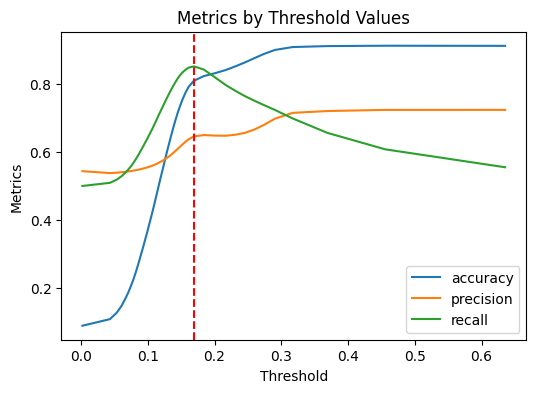

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics by Threshold Values')
plt.legend()
plt.show()

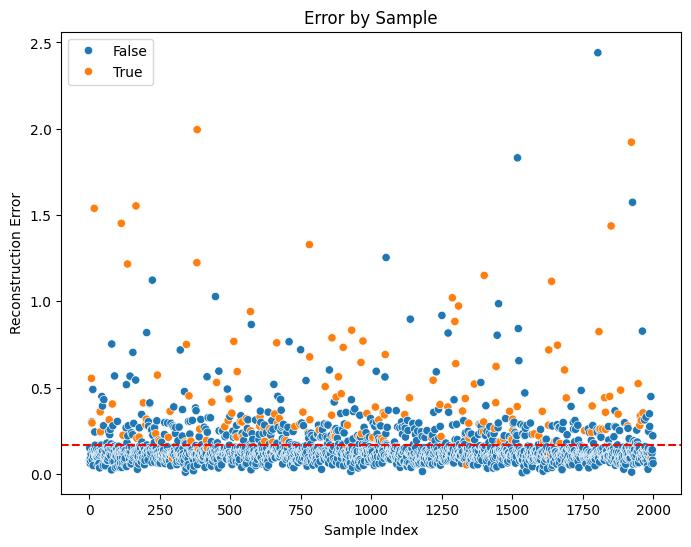

In [ ]:
temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Error by Sample')
plt.legend()
plt.show()

The red dashed line represents the threshold. Only 1% of testing data is plotted, for a clearer visualization.
* Most blue markers (representing genuine transactions) are concentrated below the threshold
* Above the threshold, more orange markers appear, indicating fraud transactions

### Classification

In [ ]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df.head()

,error,y_true,y_pred
0,0.115317,False,False
1,0.060498,False,False
2,0.302256,True,True
3,0.095656,False,False
4,0.148639,False,False


In [ ]:
central_report = classification_report(recons_df['y_true'],recons_df['y_pred'])

In [ ]:
print(central_report)

              precision    recall  f1-score   support

       False       0.99      0.80      0.89    182538
        True       0.30      0.90      0.45     17462

    accuracy                           0.81    200000
   macro avg       0.65      0.85      0.67    200000
weighted avg       0.93      0.81      0.85    200000



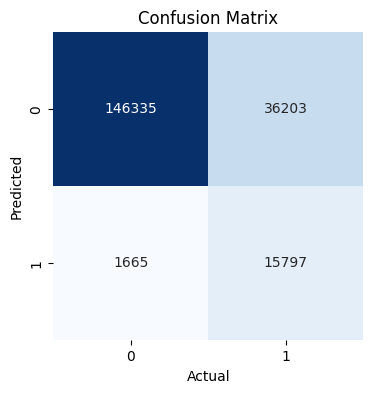

In [ ]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Results

In [ ]:
#print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.2f}%")
print(f"Accuracy Score of Centralized Model: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.2f}%")

Accuracy Score of Centralized Model: 81.07%


# Federated Learning Setup:

## Step 1: Partition the dataset into federated clients


In [ ]:
# Number of clients to simulate
n_clients = 5

# Shuffle the data to ensure randomness in splits
X_train_genuine_shuffled = X_train_genuine.sample(frac=1, random_state=42)

# Split data into n_clients equal subsets
client_data = np.array_split(X_train_genuine_shuffled, n_clients)

# Print the size of each client's dataset
for i, client in enumerate(client_data):
    print(f"Client {i+1} dataset size: {client.shape[0]}")


Client 1 dataset size: 146012
Client 2 dataset size: 146012
Client 3 dataset size: 146012
Client 4 dataset size: 146012
Client 5 dataset size: 146011


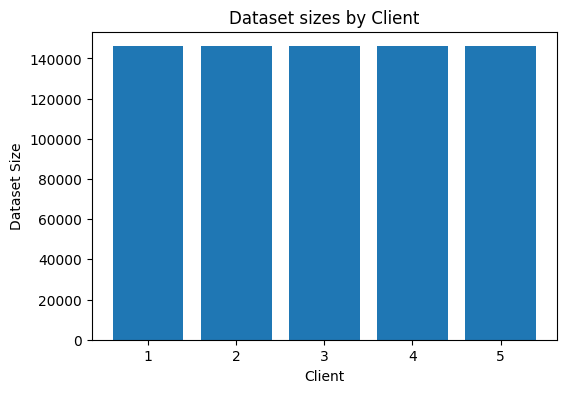

In [ ]:
# Bar plot of client dataset sizes
client_sizes = [len(client) for client in client_data]

plt.figure(figsize=(6, 4))
plt.bar(range(1, len(client_sizes)+1), client_sizes)
plt.xlabel('Client')
plt.ylabel('Dataset Size')
plt.title('Dataset sizes by Client')
plt.show()


In [ ]:
for i, client in enumerate(client_data):
    client_class_distribution = y_train.loc[client.index].value_counts()
    print(f"Client {i + 1} class distribution:")
    print(client_class_distribution)
    print()


Client 1 class distribution:
target
False    146012
Name: count, dtype: int64

Client 2 class distribution:
target
False    146012
Name: count, dtype: int64

Client 3 class distribution:
target
False    146012
Name: count, dtype: int64

Client 4 class distribution:
target
False    146012
Name: count, dtype: int64

Client 5 class distribution:
target
False    146011
Name: count, dtype: int64



In [ ]:
client_data

[        btc_transaction_fees  btc_trade_volume  btc_market_cap  \
 827503             -0.345039         -0.138191       -0.528444   
 526228             -0.396718         -0.184627       -0.365224   
 765094             -0.400998         -0.161476        0.013272   
 505726             -0.198227         -0.191333       -0.024565   
 413028             -0.236983         -0.093178        0.293763   
 ...                      ...               ...             ...   
 553428             -0.360346         -0.174830       -0.015036   
 496292              0.020837         -0.191821       -0.059677   
 691868             -0.043123         -0.193193       -0.016694   
 428083             -0.334066         -0.133460       -0.591165   
 103159             -0.342773         -0.064794        0.103961   
 
         btc_blocks_size  btc_n_transactions_per_block  btc_n_orphaned_blocks  \
 827503                1                             0                      0   
 526228                0        

### Base Model (Autoencoder):

In [ ]:
# Define the base autoencoder model using the given architecture
def base_autoencoder(input_shape, code_dim):
    input_layer = Input(shape=(input_shape,))

    # Encoder
    x = Dense(64)(input_layer)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dense(16)(x)
    x = LeakyReLU(alpha=0.01)(x)
    code = Dense(code_dim)(x)
    code = LeakyReLU(alpha=0.01)(code)

    # Decoder
    x = Dense(16)(code)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.01)(x)

    output_layer = Dense(input_shape, activation='relu')(x)

    # Create and return the model
    return Model(input_layer, output_layer, name='anomaly')



### Local Model Training for each Client:

Function to train a local autoencoder by cloning the base model.

In [ ]:
def train_local_autoencoder(client_data, base_model, epochs=30, batch_size=64):

    # Clone the base model to create a new local model
    local_autoencoder = clone_model(base_model)
    local_autoencoder.compile(optimizer='adam', loss='mae')

    # Initialize tqdm progress bar.
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        # Custom callback to update tqdm progress bar after each epoch
        class TQDMCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                pbar.update(1)

        # Train the cloned model on the client's data
        local_autoencoder.fit(
            client_data, client_data,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[TQDMCallback()]
        )

    # Return the trained model's weights
    return local_autoencoder.get_weights()


In [ ]:
# Define input shape and code dimension
CODE_DIM = 6
INPUT_SHAPE = X_train_genuine_shuffled.shape[1]

base_model = base_autoencoder(INPUT_SHAPE, CODE_DIM)

# Train local models (autoencoders) for all clients and store their weights
local_weights = []
for i, client in enumerate(client_data):
    print(f"\nTraining autoencoder for Client {i+1}...")

    # Clone the base model and train on the client data.
    client_weights = train_local_autoencoder(client, base_model, epochs=30, batch_size=64)

    # Store the trained weights
    local_weights.append(client_weights)

print("\nLocal training completed for all clients.")



Training autoencoder for Client 1...


Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 1/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2518

Training Progress:   3%|▎         | 1/30 [00:07<03:39,  7.55s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2518
Epoch 2/30
2262/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1946

Training Progress:   7%|▋         | 2/30 [00:11<02:38,  5.66s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1946
Epoch 3/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1934

Training Progress:  10%|█         | 3/30 [00:19<02:51,  6.34s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1934
Epoch 4/30
2256/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1944

Training Progress:  13%|█▎        | 4/30 [00:23<02:26,  5.64s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1944
Epoch 5/30
2270/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1952

Training Progress:  17%|█▋        | 5/30 [00:28<02:16,  5.44s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1952
Epoch 6/30
2274/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1940

Training Progress:  20%|██        | 6/30 [00:35<02:19,  5.80s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1940
Epoch 7/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1942

Training Progress:  23%|██▎       | 7/30 [00:39<02:03,  5.36s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1942
Epoch 8/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1940

Training Progress:  27%|██▋       | 8/30 [00:45<01:58,  5.40s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1940
Epoch 9/30
2257/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1940

Training Progress:  30%|███       | 9/30 [00:54<02:18,  6.59s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1940
Epoch 10/30
2260/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1932

Training Progress:  33%|███▎      | 10/30 [01:01<02:14,  6.75s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1932
Epoch 11/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1946

Training Progress:  37%|███▋      | 11/30 [01:09<02:17,  7.25s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1946
Epoch 12/30
2276/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1929

Training Progress:  40%|████      | 12/30 [01:16<02:04,  6.93s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1929
Epoch 13/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1943

Training Progress:  43%|████▎     | 13/30 [01:24<02:07,  7.53s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1943
Epoch 14/30
2256/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1938

Training Progress:  47%|████▋     | 14/30 [01:30<01:51,  6.96s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1938
Epoch 15/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1928

Training Progress:  50%|█████     | 15/30 [01:41<02:02,  8.14s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.1928
Epoch 16/30
2262/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1935

Training Progress:  53%|█████▎    | 16/30 [01:49<01:55,  8.23s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1935
Epoch 17/30
2263/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1940

Training Progress:  57%|█████▋    | 17/30 [01:56<01:38,  7.60s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1940
Epoch 18/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1945

Training Progress:  60%|██████    | 18/30 [02:00<01:19,  6.61s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1945
Epoch 19/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1939

Training Progress:  63%|██████▎   | 19/30 [02:05<01:08,  6.21s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1939
Epoch 20/30
2265/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1933

Training Progress:  67%|██████▋   | 20/30 [02:11<01:01,  6.18s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1933
Epoch 21/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1938

Training Progress:  70%|███████   | 21/30 [02:16<00:50,  5.64s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1938
Epoch 22/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1929

Training Progress:  73%|███████▎  | 22/30 [02:22<00:47,  5.97s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1929
Epoch 23/30
2263/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1940

Training Progress:  77%|███████▋  | 23/30 [02:27<00:38,  5.51s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1940
Epoch 24/30
2267/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1932

Training Progress:  80%|████████  | 24/30 [02:32<00:31,  5.32s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1932
Epoch 25/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1927

Training Progress:  83%|████████▎ | 25/30 [02:39<00:29,  5.82s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1927
Epoch 26/30
2275/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1943

Training Progress:  87%|████████▋ | 26/30 [02:44<00:22,  5.57s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1943
Epoch 27/30
2276/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1933

Training Progress:  90%|█████████ | 27/30 [02:51<00:18,  6.10s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1933
Epoch 28/30
2261/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1935

Training Progress:  93%|█████████▎| 28/30 [02:55<00:11,  5.58s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1935
Epoch 29/30
2261/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1832

Training Progress:  97%|█████████▋| 29/30 [03:00<00:05,  5.21s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1832
Epoch 30/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1807

Training Progress: 100%|██████████| 30/30 [03:06<00:00,  5.49s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1807


Training Progress: 100%|██████████| 30/30 [03:10<00:00,  6.35s/epoch]



Training autoencoder for Client 2...


Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 1/30
2276/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2875

Training Progress:   3%|▎         | 1/30 [00:07<03:47,  7.86s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2874
Epoch 2/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2712

Training Progress:   7%|▋         | 2/30 [00:12<02:48,  6.01s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2712
Epoch 3/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2712

Training Progress:  10%|█         | 3/30 [00:17<02:28,  5.50s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2712
Epoch 4/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2720

Training Progress:  13%|█▎        | 4/30 [00:24<02:36,  6.04s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2720
Epoch 5/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2701

Training Progress:  17%|█▋        | 5/30 [00:33<02:56,  7.08s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2701
Epoch 6/30
2276/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2699

Training Progress:  20%|██        | 6/30 [00:39<02:41,  6.74s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2699
Epoch 7/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2703

Training Progress:  23%|██▎       | 7/30 [00:43<02:18,  6.03s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2703
Epoch 8/30
2258/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2705

Training Progress:  27%|██▋       | 8/30 [00:50<02:18,  6.31s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2705
Epoch 9/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2700

Training Progress:  30%|███       | 9/30 [00:55<02:01,  5.77s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2700
Epoch 10/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2702

Training Progress:  33%|███▎      | 10/30 [00:59<01:48,  5.41s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2702
Epoch 11/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700

Training Progress:  37%|███▋      | 11/30 [01:06<01:52,  5.90s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2700
Epoch 12/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2708

Training Progress:  40%|████      | 12/30 [01:15<02:01,  6.74s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2708
Epoch 13/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2701

Training Progress:  43%|████▎     | 13/30 [01:21<01:51,  6.55s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2701
Epoch 14/30
2268/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2704

Training Progress:  47%|████▋     | 14/30 [01:26<01:35,  5.95s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2704
Epoch 15/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2703

Training Progress:  50%|█████     | 15/30 [01:32<01:28,  5.87s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2703
Epoch 16/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2704

Training Progress:  53%|█████▎    | 16/30 [01:41<01:35,  6.85s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2704
Epoch 17/30
2260/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2709

Training Progress:  57%|█████▋    | 17/30 [01:47<01:27,  6.71s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2709
Epoch 18/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2427

Training Progress:  60%|██████    | 18/30 [01:55<01:26,  7.19s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2426
Epoch 19/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1933

Training Progress:  63%|██████▎   | 19/30 [02:02<01:15,  6.90s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1933
Epoch 20/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1930

Training Progress:  67%|██████▋   | 20/30 [02:10<01:13,  7.40s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1930
Epoch 21/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1934

Training Progress:  70%|███████   | 21/30 [02:17<01:04,  7.20s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1934
Epoch 22/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1934

Training Progress:  73%|███████▎  | 22/30 [02:26<01:01,  7.72s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1934
Epoch 23/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1701

Training Progress:  77%|███████▋  | 23/30 [02:34<00:54,  7.73s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1700
Epoch 24/30
2259/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1609

Training Progress:  80%|████████  | 24/30 [02:41<00:45,  7.57s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1609
Epoch 25/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1606

Training Progress:  83%|████████▎ | 25/30 [02:48<00:37,  7.41s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1606
Epoch 26/30
2259/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1611

Training Progress:  87%|████████▋ | 26/30 [02:52<00:26,  6.57s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1611
Epoch 27/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1605

Training Progress:  90%|█████████ | 27/30 [02:59<00:19,  6.44s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1605
Epoch 28/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1617

Training Progress:  93%|█████████▎| 28/30 [03:08<00:14,  7.21s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1617
Epoch 29/30
2257/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1606

Training Progress:  97%|█████████▋| 29/30 [03:14<00:06,  6.96s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1606
Epoch 30/30
2274/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1618

Training Progress: 100%|██████████| 30/30 [03:19<00:00,  6.26s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1618


Training Progress: 100%|██████████| 30/30 [03:19<00:00,  6.65s/epoch]



Training autoencoder for Client 3...


Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 1/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2455

Training Progress:   3%|▎         | 1/30 [00:07<03:39,  7.58s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2454
Epoch 2/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2096

Training Progress:   7%|▋         | 2/30 [00:16<03:51,  8.27s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2096
Epoch 3/30
2264/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2090

Training Progress:  10%|█         | 3/30 [00:23<03:24,  7.58s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2090
Epoch 4/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2087

Training Progress:  13%|█▎        | 4/30 [00:31<03:27,  7.97s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2087
Epoch 5/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1953

Training Progress:  17%|█▋        | 5/30 [00:38<03:10,  7.61s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1953
Epoch 6/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1862

Training Progress:  20%|██        | 6/30 [00:47<03:11,  7.96s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1862
Epoch 7/30
2270/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1866

Training Progress:  23%|██▎       | 7/30 [00:53<02:49,  7.38s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1866
Epoch 8/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1866

Training Progress:  27%|██▋       | 8/30 [01:03<03:02,  8.31s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.1866
Epoch 9/30
2263/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1871

Training Progress:  30%|███       | 9/30 [01:08<02:31,  7.21s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1871
Epoch 10/30
2268/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1862

Training Progress:  33%|███▎      | 10/30 [01:13<02:07,  6.39s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1862
Epoch 11/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1863

Training Progress:  37%|███▋      | 11/30 [01:19<02:01,  6.39s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1863
Epoch 12/30
2258/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1867

Training Progress:  40%|████      | 12/30 [01:27<02:05,  6.97s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1867
Epoch 13/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1867

Training Progress:  43%|████▎     | 13/30 [01:34<01:58,  6.96s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1867
Epoch 14/30
2270/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1861

Training Progress:  47%|████▋     | 14/30 [01:43<01:59,  7.46s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1861
Epoch 15/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1865

Training Progress:  50%|█████     | 15/30 [01:49<01:47,  7.19s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1865
Epoch 16/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1860

Training Progress:  53%|█████▎    | 16/30 [01:54<01:29,  6.42s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1860
Epoch 17/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1860

Training Progress:  57%|█████▋    | 17/30 [02:01<01:23,  6.46s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1860
Epoch 18/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1860

Training Progress:  60%|██████    | 18/30 [02:09<01:26,  7.18s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1860
Epoch 19/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1856

Training Progress:  63%|██████▎   | 19/30 [02:18<01:22,  7.52s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1856
Epoch 20/30
2261/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1864

Training Progress:  67%|██████▋   | 20/30 [02:23<01:07,  6.80s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1864
Epoch 21/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1856

Training Progress:  70%|███████   | 21/30 [02:27<00:55,  6.13s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1856
Epoch 22/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1858

Training Progress:  73%|███████▎  | 22/30 [02:34<00:50,  6.36s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1858
Epoch 23/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1859

Training Progress:  77%|███████▋  | 23/30 [02:43<00:49,  7.01s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1859
Epoch 24/30
2257/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1856

Training Progress:  80%|████████  | 24/30 [02:49<00:41,  6.84s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1856
Epoch 25/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1863

Training Progress:  83%|████████▎ | 25/30 [02:54<00:30,  6.14s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1863
Epoch 26/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1857

Training Progress:  87%|████████▋ | 26/30 [03:00<00:24,  6.12s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1857
Epoch 27/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1865

Training Progress:  90%|█████████ | 27/30 [03:05<00:17,  5.82s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1865
Epoch 28/30
2264/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1858

Training Progress:  93%|█████████▎| 28/30 [03:09<00:10,  5.41s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1858
Epoch 29/30
2263/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1860

Training Progress:  97%|█████████▋| 29/30 [03:16<00:05,  5.66s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1860
Epoch 30/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1854

Training Progress: 100%|██████████| 30/30 [03:24<00:00,  6.48s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1854


Training Progress: 100%|██████████| 30/30 [03:25<00:00,  6.84s/epoch]



Training autoencoder for Client 4...


Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 1/30
2268/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3819

Training Progress:   3%|▎         | 1/30 [00:07<03:44,  7.74s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3819
Epoch 2/30
2265/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3770

Training Progress:   7%|▋         | 2/30 [00:11<02:39,  5.69s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3770
Epoch 3/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3776

Training Progress:  10%|█         | 3/30 [00:18<02:48,  6.25s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.3776
Epoch 4/30
2267/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3776

Training Progress:  13%|█▎        | 4/30 [00:23<02:24,  5.54s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3776
Epoch 5/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3768

Training Progress:  17%|█▋        | 5/30 [00:27<02:07,  5.10s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3768
Epoch 6/30
2262/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3775

Training Progress:  20%|██        | 6/30 [00:34<02:14,  5.59s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.3775
Epoch 7/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3771

Training Progress:  23%|██▎       | 7/30 [00:43<02:32,  6.64s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3771
Epoch 8/30
2267/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3761

Training Progress:  27%|██▋       | 8/30 [00:49<02:22,  6.47s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3761
Epoch 9/30
2264/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3770

Training Progress:  30%|███       | 9/30 [00:57<02:31,  7.21s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3770
Epoch 10/30
2265/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3748

Training Progress:  33%|███▎      | 10/30 [01:03<02:14,  6.70s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3748
Epoch 11/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3640

Training Progress:  37%|███▋      | 11/30 [01:13<02:27,  7.76s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.3640
Epoch 12/30
2275/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3643

Training Progress:  40%|████      | 12/30 [01:22<02:27,  8.19s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.3643
Epoch 13/30
2275/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3647

Training Progress:  43%|████▎     | 13/30 [01:30<02:17,  8.08s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3647
Epoch 14/30
2262/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3639

Training Progress:  47%|████▋     | 14/30 [01:38<02:05,  7.87s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.3639
Epoch 15/30
2264/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3647

Training Progress:  50%|█████     | 15/30 [01:44<01:51,  7.44s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3647
Epoch 16/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3641

Training Progress:  53%|█████▎    | 16/30 [01:54<01:53,  8.13s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.3641
Epoch 17/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3639

Training Progress:  57%|█████▋    | 17/30 [01:59<01:34,  7.24s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3639
Epoch 18/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3646

Training Progress:  60%|██████    | 18/30 [02:10<01:40,  8.39s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.3646
Epoch 19/30
2263/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3646

Training Progress:  63%|██████▎   | 19/30 [02:18<01:32,  8.41s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3646
Epoch 20/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3641

Training Progress:  67%|██████▋   | 20/30 [02:24<01:16,  7.69s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3641
Epoch 21/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3630

Training Progress:  70%|███████   | 21/30 [02:29<01:00,  6.68s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3630
Epoch 22/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3644

Training Progress:  73%|███████▎  | 22/30 [02:34<00:49,  6.24s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3644
Epoch 23/30
2270/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3641

Training Progress:  77%|███████▋  | 23/30 [02:40<00:43,  6.23s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3641
Epoch 24/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2892

Training Progress:  80%|████████  | 24/30 [02:44<00:33,  5.63s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2892
Epoch 25/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2382

Training Progress:  83%|████████▎ | 25/30 [02:50<00:27,  5.55s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2382
Epoch 26/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2395

Training Progress:  87%|████████▋ | 26/30 [02:55<00:21,  5.46s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2395
Epoch 27/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2386

Training Progress:  90%|█████████ | 27/30 [02:59<00:15,  5.10s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2386
Epoch 28/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2382

Training Progress:  93%|█████████▎| 28/30 [03:05<00:10,  5.25s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2382
Epoch 29/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2391

Training Progress:  97%|█████████▋| 29/30 [03:10<00:05,  5.06s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2391
Epoch 30/30
2274/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2389

Training Progress: 100%|██████████| 30/30 [03:14<00:00,  4.98s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2389


Training Progress: 100%|██████████| 30/30 [03:15<00:00,  6.52s/epoch]



Training autoencoder for Client 5...


Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 1/30
2257/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2124

Training Progress:   3%|▎         | 1/30 [00:07<03:29,  7.23s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2120
Epoch 2/30
2259/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1529

Training Progress:   7%|▋         | 2/30 [00:11<02:34,  5.51s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1529
Epoch 3/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1370

Training Progress:  10%|█         | 3/30 [00:16<02:28,  5.48s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1370
Epoch 4/30
2265/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1327

Training Progress:  13%|█▎        | 4/30 [00:21<02:16,  5.25s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1327
Epoch 5/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1319

Training Progress:  17%|█▋        | 5/30 [00:26<02:04,  4.97s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1319
Epoch 6/30
2256/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1315

Training Progress:  20%|██        | 6/30 [00:33<02:16,  5.68s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1315
Epoch 7/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1314

Training Progress:  23%|██▎       | 7/30 [00:41<02:30,  6.54s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1314
Epoch 8/30
2263/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1307

Training Progress:  27%|██▋       | 8/30 [00:48<02:25,  6.61s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1307
Epoch 9/30
2258/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1308

Training Progress:  30%|███       | 9/30 [00:52<02:03,  5.87s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1308
Epoch 10/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1304

Training Progress:  33%|███▎      | 10/30 [00:58<01:59,  5.96s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1304
Epoch 11/30
2274/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1305

Training Progress:  37%|███▋      | 11/30 [01:04<01:49,  5.74s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1305
Epoch 12/30
2254/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1299

Training Progress:  40%|████      | 12/30 [01:08<01:35,  5.29s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1299
Epoch 13/30
2258/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1304

Training Progress:  43%|████▎     | 13/30 [01:15<01:37,  5.74s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1304
Epoch 14/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1296

Training Progress:  47%|████▋     | 14/30 [01:23<01:45,  6.61s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1296
Epoch 15/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1302

Training Progress:  50%|█████     | 15/30 [01:30<01:37,  6.50s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1302
Epoch 16/30
2254/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1298

Training Progress:  53%|█████▎    | 16/30 [01:36<01:30,  6.44s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1298
Epoch 17/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1296

Training Progress:  57%|█████▋    | 17/30 [01:41<01:18,  6.07s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1296
Epoch 18/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1291

Training Progress:  60%|██████    | 18/30 [01:46<01:09,  5.83s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1291
Epoch 19/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1295

Training Progress:  63%|██████▎   | 19/30 [01:51<00:59,  5.41s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1295
Epoch 20/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1289

Training Progress:  67%|██████▋   | 20/30 [01:58<00:58,  5.84s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1289
Epoch 21/30
2267/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1286

Training Progress:  70%|███████   | 21/30 [02:06<01:00,  6.67s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1286
Epoch 22/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1293

Training Progress:  73%|███████▎  | 22/30 [02:12<00:52,  6.54s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1293
Epoch 23/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1287

Training Progress:  77%|███████▋  | 23/30 [02:17<00:41,  5.87s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1287
Epoch 24/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1290

Training Progress:  80%|████████  | 24/30 [02:21<00:32,  5.41s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1290
Epoch 25/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1292

Training Progress:  83%|████████▎ | 25/30 [02:27<00:28,  5.63s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1292
Epoch 26/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1293

Training Progress:  87%|████████▋ | 26/30 [02:36<00:26,  6.50s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1293
Epoch 27/30
2265/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1290

Training Progress:  90%|█████████ | 27/30 [02:42<00:19,  6.40s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1290
Epoch 28/30
2259/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1292

Training Progress:  93%|█████████▎| 28/30 [02:50<00:14,  7.04s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1292
Epoch 29/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1289

Training Progress:  97%|█████████▋| 29/30 [02:57<00:06,  6.74s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1289
Epoch 30/30
2270/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1288

Training Progress: 100%|██████████| 30/30 [03:01<00:00,  6.02s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1288


Training Progress: 100%|██████████| 30/30 [03:02<00:00,  6.07s/epoch]


Local training completed for all clients.


### Step 3: Global Model Aggregation:

Federated Averaging (FedAvg) workflow.

In [ ]:
# Aggregate weights from all clients to form the global model
def aggregate_weights(local_weights):
    """Aggregate weights from all clients by averaging."""
    # Transpose the list of weights (list of lists) to group layers together
    num_clients = len(local_weights)
    aggregated_weights = []

    for layer_idx, layer_weights in enumerate(zip(*local_weights)):
        # Compute the average weights for each layer
        layer_avg = sum(layer_weights) / num_clients
        aggregated_weights.append(layer_avg)

        print(f"Layer {layer_idx + 1} aggregated.")

    return aggregated_weights


In [ ]:
# Create a global model with the architecture defined explicitly
def Global_model(input_shape, code_dim):

    input_layer = tf.keras.Input(shape=(input_shape,))

    # Encoder
    x = tf.keras.layers.Dense(64)(input_layer)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    x = tf.keras.layers.Dense(16)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    code = tf.keras.layers.Dense(code_dim)(x)
    code = tf.keras.layers.LeakyReLU(alpha=0.01)(code)

    # Decoder
    x = tf.keras.layers.Dense(16)(code)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)

    output_layer = tf.keras.layers.Dense(input_shape, activation='relu')(x)

    # Create and return the global autoencoder model
    global_autoencoder = tf.keras.Model(input_layer, output_layer, name='global_autoencoder')
    global_autoencoder.compile(optimizer='adam', loss='mae')

    return global_autoencoder


In [ ]:
CODE_DIM = 6
INPUT_SHAPE = X_train_genuine_shuffled.shape[1]

# Initialize the global model
global_autoencoder = Global_model(INPUT_SHAPE, CODE_DIM)

# Aggregate the weights from local models
global_weights = aggregate_weights(local_weights)

# Update the global model with aggregated weights
global_autoencoder.set_weights(global_weights)

print("Global model updated with aggregated weights.")


Layer 1 aggregated.
Layer 2 aggregated.
Layer 3 aggregated.
Layer 4 aggregated.
Layer 5 aggregated.
Layer 6 aggregated.
Layer 7 aggregated.
Layer 8 aggregated.
Layer 9 aggregated.
Layer 10 aggregated.
Layer 11 aggregated.
Layer 12 aggregated.
Global model updated with aggregated weights.


### Save Global model after updating aggregated weights:

In [ ]:
# Save the global model in the new Keras format
global_autoencoder.save('global_autoencoder.keras')
print("Global model saved successfully.")


Global model saved successfully.


In [ ]:
# Load the saved global autoencoder model
loaded_global_autoencoder = load_model('/content/Global_Model.keras')
print("Global model loaded successfully.")


Global model loaded successfully.


## Results of Federated Model:

In [ ]:
# Use this when loaded global model is used.

global_reconstructions = loaded_global_autoencoder.predict(X_test, verbose=1)
global_reconstruction_error = mae(global_reconstructions, X_test)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [ ]:
# Use this when already run the training process of global model.

global_reconstructions = global_autoencoder.predict(X_test, verbose=1)
global_reconstruction_error = mae(global_reconstructions, X_test)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


In [ ]:
federated_reconstruction_error_np = global_reconstruction_error.numpy()

fed_threshold = np.quantile(federated_reconstruction_error_np, 0.85)

In [ ]:
federated_df = pd.DataFrame({
    'error': federated_reconstruction_error_np,
    'y_true': y_test
}).reset_index(drop=True)

federated_df.head()

,error,y_true
0,0.362959,False
1,0.189514,False
2,0.551602,True
3,0.353072,False
4,0.447533,False


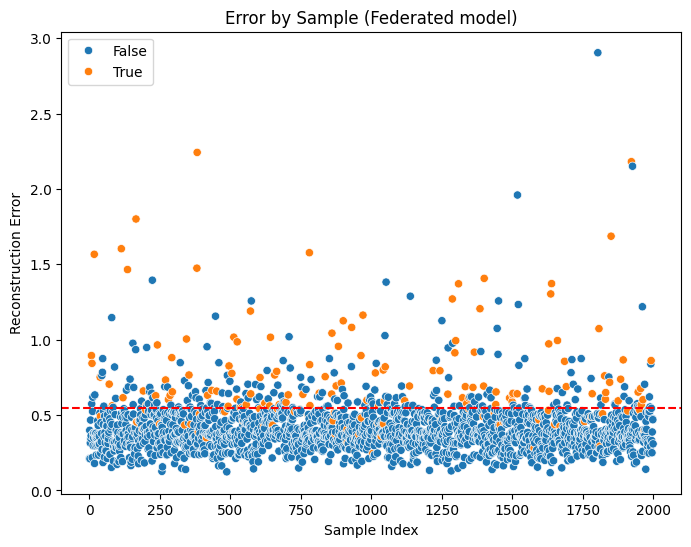

In [ ]:
fed_temp = federated_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.scatterplot(data=fed_temp, x=fed_temp.index, y='error', hue='y_true')
plt.axhline(y=fed_threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Error by Sample (Federated model)')
plt.legend()
plt.show()

### Classification:

In [ ]:
federated_df['y_pred'] = federated_df['error'] > fed_threshold
federated_df.head()

,error,y_true,y_pred
0,0.362959,False,False
1,0.189514,False,False
2,0.551602,True,True
3,0.353072,False,False
4,0.447533,False,False


In [ ]:
federated_report = classification_report(federated_df['y_true'],federated_df['y_pred'])

In [ ]:
print(federated_report)

              precision    recall  f1-score   support

       False       0.97      0.90      0.93    182538
        True       0.39      0.66      0.49     17462

    accuracy                           0.88    200000
   macro avg       0.68      0.78      0.71    200000
weighted avg       0.92      0.88      0.89    200000



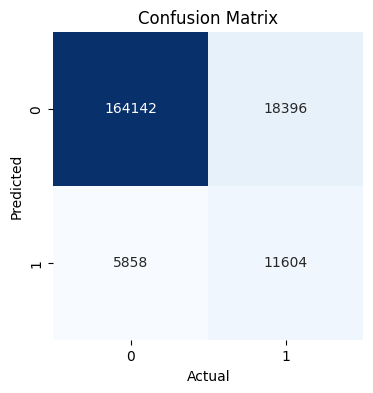

In [ ]:
cm = confusion_matrix(federated_df['y_true'],federated_df['y_pred'])
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Federated Result:

In [ ]:
#print(f"Recall Score: {recall_score(federated_df['y_true'],federated_df['y_pred'])*100:.2f}%")
print(f"Accuracy Score of Federated Model: {accuracy_score(federated_df['y_true'],federated_df['y_pred'])*100:.2f}%")

Accuracy Score of Federated Model: 87.87%


## Performance Comparisons and Visualizations:

### Step 1: Evaluate Reconstruction Error:

Centralized model:

In [ ]:
# Centralized model reconstruction error
central_reconstructions = L_autoencoder.predict(X_test, verbose=1)
central_reconstruction_error = mae(central_reconstructions, X_test)


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


Federated model:

In [ ]:
# Federated model reconstruction error
federated_reconstructions = loaded_global_autoencoder.predict(X_test, verbose=1)
federated_reconstruction_error = mae(federated_reconstructions, X_test)


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


Compare distributions:

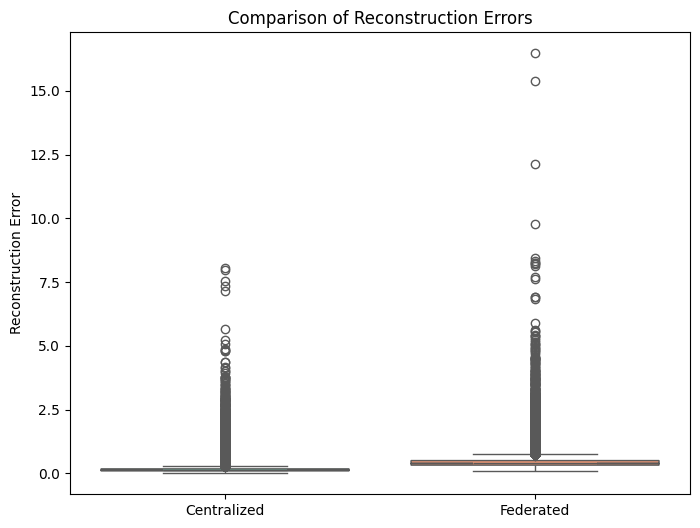

In [ ]:
# Plot reconstruction error distributions
plt.figure(figsize=(8,6))
sns.boxplot(data=[
    central_reconstruction_error,
    federated_reconstruction_error
], palette="Set2", notch=True)
plt.xticks([0, 1], ['Centralized', 'Federated'])
plt.ylabel('Reconstruction Error')
plt.title('Comparison of Reconstruction Errors')
plt.show()


##  Anomaly Detection Performance using ROC Curve:

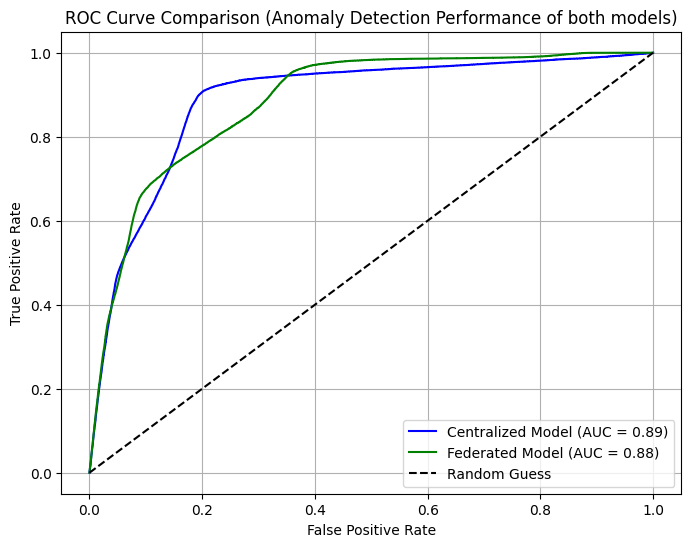

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Centralized ROC Curve
fpr_c, tpr_c, _ = roc_curve(recons_df['y_true'], recons_df['error'])
roc_auc_c = auc(fpr_c, tpr_c)

# Federated ROC Curve
fpr_f, tpr_f, _ = roc_curve(federated_df['y_true'], federated_df['error'])
roc_auc_f = auc(fpr_f, tpr_f)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, label=f'Centralized Model (AUC = {roc_auc_c:.2f})', color='blue')
plt.plot(fpr_f, tpr_f, label=f'Federated Model (AUC = {roc_auc_f:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Anomaly Detection Performance of both models)')
plt.legend()
plt.grid()
plt.show()


### Computational Efficiency:

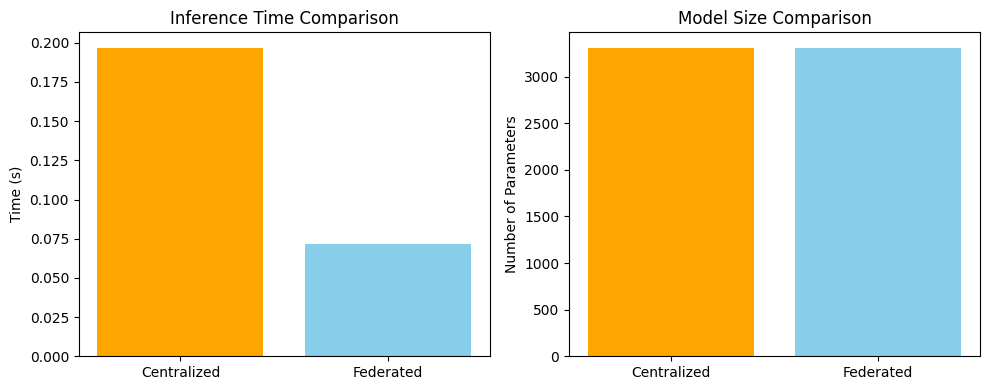

In [ ]:
import time

# Measure inference time for both models
def measure_inference_time(model, X_test_sample, iterations=100):
    start_time = time.time()
    for _ in range(iterations):
        _ = model.predict(X_test_sample, verbose=0)
    end_time = time.time()
    avg_time = (end_time - start_time) / iterations
    return avg_time

# Random sample for inference test
X_test_sample = X_test.sample(1)

# Inference Time
time_centralized = measure_inference_time(L_autoencoder, X_test_sample)
time_federated = measure_inference_time(global_autoencoder, X_test_sample)

# Model Sizes
size_centralized = L_autoencoder.count_params()
size_federated = global_autoencoder.count_params()

# Bar Chart for Comparison
labels = ['Centralized', 'Federated']
inference_times = [time_centralized, time_federated]
model_sizes = [size_centralized, size_federated]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Inference Time Bar Chart
ax[0].bar(labels, inference_times, color=['orange', 'skyblue'])
ax[0].set_title('Inference Time Comparison')
ax[0].set_ylabel('Time (s)')

# Model Size Bar Chart
ax[1].bar(labels, model_sizes, color=['orange', 'skyblue'])
ax[1].set_title('Model Size Comparison')
ax[1].set_ylabel('Number of Parameters')

plt.tight_layout()
plt.show()


#### Step 3: Training Efficiency
Track and compare training times:

In [ ]:
import time

# Track training time for centralized model
start_time = time.time()
L_autoencoder.fit(X_train_genuine, X_train_genuine, epochs=30, batch_size=64)
centralized_training_time = time.time() - start_time
print(f"\nCentralized model training time: {centralized_training_time:.3f} seconds")

base_model = base_autoencoder(INPUT_SHAPE, CODE_DIM)

# Track training time for federated model
client_times = []
for i, client in enumerate(client_data):
    start_time = time.time()
    train_local_autoencoder(client, base_model, epochs=30, batch_size=64)
    client_times.append(time.time() - start_time)

federated_training_time = sum(client_times)
print(f"\nFederated model training time: {federated_training_time:.3f} seconds")


Epoch 1/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.1494
Epoch 2/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.1495
Epoch 3/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.1493
Epoch 4/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.1491
Epoch 5/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.1496
Epoch 6/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.1495
Epoch 7/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.1492
Epoch 8/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 0.1494
Epoch 9/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.1492
Epoch 10/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.1491
Epoch 11/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.1492
Epoch 12/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.1496
Epoch 13/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.1492
Epoch 14/30
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - 

Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 1/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2372

Training Progress:   3%|▎         | 1/30 [00:08<03:53,  8.04s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2371
Epoch 2/30
2256/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2147

Training Progress:   7%|▋         | 2/30 [00:12<02:45,  5.91s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2147
Epoch 3/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2154

Training Progress:  10%|█         | 3/30 [00:17<02:27,  5.48s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2154
Epoch 4/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2150

Training Progress:  13%|█▎        | 4/30 [00:24<02:42,  6.25s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2150
Epoch 5/30
2274/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2153

Training Progress:  17%|█▋        | 5/30 [00:32<02:51,  6.87s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2153
Epoch 6/30
2267/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2158

Training Progress:  20%|██        | 6/30 [00:42<03:06,  7.77s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2158
Epoch 7/30
2267/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2149

Training Progress:  23%|██▎       | 7/30 [00:49<02:51,  7.44s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2149
Epoch 8/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2158

Training Progress:  27%|██▋       | 8/30 [00:53<02:24,  6.58s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2158
Epoch 9/30
2256/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2155

Training Progress:  30%|███       | 9/30 [00:58<02:04,  5.92s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2155
Epoch 10/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2145

Training Progress:  33%|███▎      | 10/30 [01:05<02:06,  6.31s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2145
Epoch 11/30
2264/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2140

Training Progress:  37%|███▋      | 11/30 [01:10<01:49,  5.79s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2140
Epoch 12/30
2270/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2158

Training Progress:  40%|████      | 12/30 [01:16<01:49,  6.06s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2158
Epoch 13/30
2267/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2157

Training Progress:  43%|████▎     | 13/30 [01:21<01:37,  5.75s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2157
Epoch 14/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2168

Training Progress:  47%|████▋     | 14/30 [01:26<01:26,  5.41s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2168
Epoch 15/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2157

Training Progress:  50%|█████     | 15/30 [01:33<01:28,  5.90s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2157
Epoch 16/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2152

Training Progress:  53%|█████▎    | 16/30 [01:41<01:33,  6.65s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2152
Epoch 17/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2149

Training Progress:  57%|█████▋    | 17/30 [01:48<01:26,  6.67s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2149
Epoch 18/30
2268/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2150

Training Progress:  60%|██████    | 18/30 [01:53<01:12,  6.05s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2150
Epoch 19/30
2265/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2150

Training Progress:  63%|██████▎   | 19/30 [01:59<01:08,  6.26s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2150
Epoch 20/30
2259/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2142

Training Progress:  67%|██████▋   | 20/30 [02:08<01:09,  6.94s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2142
Epoch 21/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1981

Training Progress:  70%|███████   | 21/30 [02:15<01:01,  6.87s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1980
Epoch 22/30
2264/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1946

Training Progress:  73%|███████▎  | 22/30 [02:23<00:59,  7.43s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1946
Epoch 23/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1942

Training Progress:  77%|███████▋  | 23/30 [02:30<00:49,  7.08s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1942
Epoch 24/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1941

Training Progress:  80%|████████  | 24/30 [02:38<00:44,  7.50s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1941
Epoch 25/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1955

Training Progress:  83%|████████▎ | 25/30 [02:45<00:35,  7.19s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1955
Epoch 26/30
2261/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1941

Training Progress:  87%|████████▋ | 26/30 [02:49<00:25,  6.48s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1940
Epoch 27/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1931

Training Progress:  90%|█████████ | 27/30 [02:55<00:18,  6.18s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1931
Epoch 28/30
2264/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1948

Training Progress:  93%|█████████▎| 28/30 [03:02<00:13,  6.50s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1948
Epoch 29/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1948

Training Progress:  97%|█████████▋| 29/30 [03:12<00:07,  7.41s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.1948
Epoch 30/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1933

Training Progress: 100%|██████████| 30/30 [03:20<00:00,  7.78s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1933


Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 1/30
2265/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1931

Training Progress:   3%|▎         | 1/30 [00:07<03:51,  7.97s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1929
Epoch 2/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1520

Training Progress:   7%|▋         | 2/30 [00:18<04:32,  9.71s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.1520
Epoch 3/30
2275/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1514

Training Progress:  10%|█         | 3/30 [00:27<04:10,  9.28s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1514
Epoch 4/30
2259/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1514

Training Progress:  13%|█▎        | 4/30 [00:34<03:34,  8.26s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1514
Epoch 5/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1517

Training Progress:  17%|█▋        | 5/30 [00:43<03:32,  8.49s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1517
Epoch 6/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1514

Training Progress:  20%|██        | 6/30 [00:53<03:35,  8.96s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1514
Epoch 7/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1510

Training Progress:  23%|██▎       | 7/30 [00:59<03:09,  8.24s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1510
Epoch 8/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1511

Training Progress:  27%|██▋       | 8/30 [01:04<02:36,  7.14s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1511
Epoch 9/30
2275/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1505

Training Progress:  30%|███       | 9/30 [01:09<02:13,  6.36s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1505
Epoch 10/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1508

Training Progress:  33%|███▎      | 10/30 [01:15<02:07,  6.37s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1508
Epoch 11/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1511

Training Progress:  37%|███▋      | 11/30 [01:24<02:14,  7.10s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1511
Epoch 12/30
2264/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1509

Training Progress:  40%|████      | 12/30 [01:30<02:02,  6.82s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1509
Epoch 13/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1512

Training Progress:  43%|████▎     | 13/30 [01:35<01:44,  6.13s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1512
Epoch 14/30
2275/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1507

Training Progress:  47%|████▋     | 14/30 [01:41<01:40,  6.30s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1507
Epoch 15/30
2276/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1502

Training Progress:  50%|█████     | 15/30 [01:50<01:44,  6.98s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1503
Epoch 16/30
2260/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1510

Training Progress:  53%|█████▎    | 16/30 [01:57<01:39,  7.07s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1510
Epoch 17/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1503

Training Progress:  57%|█████▋    | 17/30 [02:05<01:36,  7.40s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1503
Epoch 18/30
2255/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1506

Training Progress:  60%|██████    | 18/30 [02:12<01:26,  7.20s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1506
Epoch 19/30
2268/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1503

Training Progress:  63%|██████▎   | 19/30 [02:17<01:10,  6.42s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1503
Epoch 20/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1504

Training Progress:  67%|██████▋   | 20/30 [02:22<01:02,  6.22s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1504
Epoch 21/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1504

Training Progress:  70%|███████   | 21/30 [02:28<00:54,  6.11s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1504
Epoch 22/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1500

Training Progress:  73%|███████▎  | 22/30 [02:33<00:45,  5.75s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1500
Epoch 23/30
2274/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1501

Training Progress:  77%|███████▋  | 23/30 [02:40<00:41,  5.96s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1501
Epoch 24/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1506

Training Progress:  80%|████████  | 24/30 [02:44<00:33,  5.58s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1506
Epoch 25/30
2267/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1500

Training Progress:  83%|████████▎ | 25/30 [02:50<00:27,  5.51s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1500
Epoch 26/30
2275/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1501

Training Progress:  87%|████████▋ | 26/30 [02:56<00:22,  5.70s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1501
Epoch 27/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1502

Training Progress:  90%|█████████ | 27/30 [03:06<00:20,  6.92s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1502
Epoch 28/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1503

Training Progress:  93%|█████████▎| 28/30 [03:11<00:12,  6.43s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1503
Epoch 29/30
2276/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1502

Training Progress:  97%|█████████▋| 29/30 [03:15<00:05,  5.83s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1502
Epoch 30/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1501

Training Progress: 100%|██████████| 30/30 [03:21<00:00,  5.84s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1501


Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 1/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2571

Training Progress:   3%|▎         | 1/30 [00:06<03:18,  6.83s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2571
Epoch 2/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2292

Training Progress:   7%|▋         | 2/30 [00:13<03:01,  6.49s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2292
Epoch 3/30
2258/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2176

Training Progress:  10%|█         | 3/30 [00:17<02:32,  5.66s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2176
Epoch 4/30
2276/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2177

Training Progress:  13%|█▎        | 4/30 [00:24<02:42,  6.26s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2177
Epoch 5/30
2274/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2166

Training Progress:  17%|█▋        | 5/30 [00:29<02:22,  5.68s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2166
Epoch 6/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2168

Training Progress:  20%|██        | 6/30 [00:34<02:11,  5.48s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2168
Epoch 7/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2169

Training Progress:  23%|██▎       | 7/30 [00:41<02:12,  5.78s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2169
Epoch 8/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2173

Training Progress:  27%|██▋       | 8/30 [00:50<02:33,  6.98s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2173
Epoch 9/30
2265/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2166

Training Progress:  30%|███       | 9/30 [01:00<02:44,  7.84s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2166
Epoch 10/30
2265/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2161

Training Progress:  33%|███▎      | 10/30 [01:07<02:30,  7.52s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2161
Epoch 11/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2167

Training Progress:  37%|███▋      | 11/30 [01:11<02:07,  6.70s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2167
Epoch 12/30
2268/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2169

Training Progress:  40%|████      | 12/30 [01:16<01:51,  6.18s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2169
Epoch 13/30
2259/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2164

Training Progress:  43%|████▎     | 13/30 [01:24<01:53,  6.69s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2164
Epoch 14/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2170

Training Progress:  47%|████▋     | 14/30 [01:29<01:37,  6.10s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2170
Epoch 15/30
2270/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2163

Training Progress:  50%|█████     | 15/30 [01:36<01:33,  6.21s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2163
Epoch 16/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2168

Training Progress:  53%|█████▎    | 16/30 [01:44<01:35,  6.84s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2168
Epoch 17/30
2274/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2169

Training Progress:  57%|█████▋    | 17/30 [01:51<01:29,  6.90s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2169
Epoch 18/30
2270/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2169

Training Progress:  60%|██████    | 18/30 [02:00<01:28,  7.42s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2169
Epoch 19/30
2264/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2162

Training Progress:  63%|██████▎   | 19/30 [02:06<01:19,  7.25s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2162
Epoch 20/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2167

Training Progress:  67%|██████▋   | 20/30 [02:11<01:04,  6.49s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2167
Epoch 21/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2170

Training Progress:  70%|███████   | 21/30 [02:17<00:56,  6.33s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2169
Epoch 22/30
2258/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2164

Training Progress:  73%|███████▎  | 22/30 [02:27<00:58,  7.37s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2164
Epoch 23/30
2261/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2166

Training Progress:  77%|███████▋  | 23/30 [02:34<00:50,  7.26s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2165
Epoch 24/30
2255/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2160

Training Progress:  80%|████████  | 24/30 [02:42<00:44,  7.44s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2160
Epoch 25/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2163

Training Progress:  83%|████████▎ | 25/30 [02:48<00:35,  7.13s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2163
Epoch 26/30
2264/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2162

Training Progress:  87%|████████▋ | 26/30 [02:53<00:25,  6.39s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2162
Epoch 27/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2165

Training Progress:  90%|█████████ | 27/30 [02:58<00:17,  6.00s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2165
Epoch 28/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2167

Training Progress:  93%|█████████▎| 28/30 [03:04<00:12,  6.01s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2167
Epoch 29/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2158

Training Progress:  97%|█████████▋| 29/30 [03:08<00:05,  5.58s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2158
Epoch 30/30
2275/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2162

Training Progress: 100%|██████████| 30/30 [03:15<00:00,  5.77s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2162


Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 1/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2387

Training Progress:   3%|▎         | 1/30 [00:06<03:04,  6.36s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2387
Epoch 2/30
2265/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2142

Training Progress:   7%|▋         | 2/30 [00:13<03:11,  6.85s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2141
Epoch 3/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2129

Training Progress:  10%|█         | 3/30 [00:22<03:32,  7.88s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2129
Epoch 4/30
2255/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2116

Training Progress:  13%|█▎        | 4/30 [00:31<03:38,  8.42s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2116
Epoch 5/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2125

Training Progress:  17%|█▋        | 5/30 [00:38<03:13,  7.74s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2125
Epoch 6/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2121

Training Progress:  20%|██        | 6/30 [00:46<03:10,  7.95s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2121
Epoch 7/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2095

Training Progress:  23%|██▎       | 7/30 [00:53<02:53,  7.54s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2095
Epoch 8/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2078

Training Progress:  27%|██▋       | 8/30 [01:01<02:52,  7.83s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2078
Epoch 9/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2084

Training Progress:  30%|███       | 9/30 [01:08<02:37,  7.51s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2084
Epoch 10/30
2260/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2088

Training Progress:  33%|███▎      | 10/30 [01:13<02:14,  6.72s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2088
Epoch 11/30
2268/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2081

Training Progress:  37%|███▋      | 11/30 [01:19<02:04,  6.56s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2081
Epoch 12/30
2270/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2080

Training Progress:  40%|████      | 12/30 [01:25<01:50,  6.14s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2080
Epoch 13/30
2267/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2083

Training Progress:  43%|████▎     | 13/30 [01:29<01:36,  5.70s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2083
Epoch 14/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2074

Training Progress:  47%|████▋     | 14/30 [01:36<01:37,  6.08s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2074
Epoch 15/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2079

Training Progress:  50%|█████     | 15/30 [01:41<01:26,  5.74s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2079
Epoch 16/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2084

Training Progress:  53%|█████▎    | 16/30 [01:47<01:20,  5.75s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2084
Epoch 17/30
2260/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2079

Training Progress:  57%|█████▋    | 17/30 [01:56<01:28,  6.81s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2079
Epoch 18/30
2267/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2076

Training Progress:  60%|██████    | 18/30 [02:03<01:21,  6.81s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2076
Epoch 19/30
2259/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2076

Training Progress:  63%|██████▎   | 19/30 [02:12<01:22,  7.47s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2076
Epoch 20/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2072

Training Progress:  67%|██████▋   | 20/30 [02:19<01:12,  7.26s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2072
Epoch 21/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2078

Training Progress:  70%|███████   | 21/30 [02:24<00:58,  6.49s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2078
Epoch 22/30
2270/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2084

Training Progress:  73%|███████▎  | 22/30 [02:29<00:49,  6.24s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2084
Epoch 23/30
2264/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2073

Training Progress:  77%|███████▋  | 23/30 [02:35<00:42,  6.08s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2073
Epoch 24/30
2267/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2076

Training Progress:  80%|████████  | 24/30 [02:40<00:35,  5.84s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2076
Epoch 25/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2073

Training Progress:  83%|████████▎ | 25/30 [02:47<00:31,  6.22s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2073
Epoch 26/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2084

Training Progress:  87%|████████▋ | 26/30 [02:56<00:28,  7.03s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2084
Epoch 27/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2074

Training Progress:  90%|█████████ | 27/30 [03:06<00:23,  7.80s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2074
Epoch 28/30
2275/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2069

Training Progress:  93%|█████████▎| 28/30 [03:18<00:18,  9.01s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.2069
Epoch 29/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2082

Training Progress:  97%|█████████▋| 29/30 [03:24<00:08,  8.25s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2082
Epoch 30/30
2265/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2081

Training Progress: 100%|██████████| 30/30 [03:33<00:00,  8.46s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2081


Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 1/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2002

Training Progress:   3%|▎         | 1/30 [00:07<03:42,  7.67s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2001
Epoch 2/30
2263/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1498

Training Progress:   7%|▋         | 2/30 [00:17<04:15,  9.14s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1498
Epoch 3/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1435

Training Progress:  10%|█         | 3/30 [00:24<03:32,  7.86s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1435
Epoch 4/30
2270/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1434

Training Progress:  13%|█▎        | 4/30 [00:29<03:02,  7.04s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1434
Epoch 5/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1438

Training Progress:  17%|█▋        | 5/30 [00:41<03:37,  8.69s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.1438
Epoch 6/30
2279/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1435

Training Progress:  20%|██        | 6/30 [00:46<02:59,  7.47s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1435
Epoch 7/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1430

Training Progress:  23%|██▎       | 7/30 [00:53<02:43,  7.10s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1430
Epoch 8/30
2269/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1420

Training Progress:  27%|██▋       | 8/30 [01:02<02:52,  7.83s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1420
Epoch 9/30
2260/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1426

Training Progress:  30%|███       | 9/30 [01:09<02:38,  7.53s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1426
Epoch 10/30
2261/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1425

Training Progress:  33%|███▎      | 10/30 [01:14<02:13,  6.67s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1425
Epoch 11/30
2268/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1427

Training Progress:  37%|███▋      | 11/30 [01:19<02:01,  6.38s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1427
Epoch 12/30
2266/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1422

Training Progress:  40%|████      | 12/30 [01:25<01:52,  6.28s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1422
Epoch 13/30
2276/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1425

Training Progress:  43%|████▎     | 13/30 [01:37<02:12,  7.80s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.1425
Epoch 14/30
2275/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1429

Training Progress:  47%|████▋     | 14/30 [01:42<01:51,  6.96s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1429
Epoch 15/30
2278/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1429

Training Progress:  50%|█████     | 15/30 [01:47<01:36,  6.44s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1429
Epoch 16/30
2271/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1434

Training Progress:  53%|█████▎    | 16/30 [01:54<01:31,  6.52s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1434
Epoch 17/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1424

Training Progress:  57%|█████▋    | 17/30 [01:59<01:18,  6.05s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1424
Epoch 18/30
2261/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1424

Training Progress:  60%|██████    | 18/30 [02:06<01:16,  6.36s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1424
Epoch 19/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1424

Training Progress:  63%|██████▎   | 19/30 [02:10<01:05,  5.92s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1424
Epoch 20/30
2281/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1425

Training Progress:  67%|██████▋   | 20/30 [02:15<00:56,  5.64s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1425
Epoch 21/30
2274/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1423

Training Progress:  70%|███████   | 21/30 [02:22<00:53,  5.95s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1423
Epoch 22/30
2261/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1429

Training Progress:  73%|███████▎  | 22/30 [02:27<00:45,  5.63s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1429
Epoch 23/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1429

Training Progress:  77%|███████▋  | 23/30 [02:33<00:41,  5.88s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1429
Epoch 24/30
2273/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1427

Training Progress:  80%|████████  | 24/30 [02:43<00:41,  6.87s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1427
Epoch 25/30
2257/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1419

Training Progress:  83%|████████▎ | 25/30 [02:50<00:34,  6.91s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1419
Epoch 26/30
2282/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1421

Training Progress:  87%|████████▋ | 26/30 [02:55<00:25,  6.36s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1421
Epoch 27/30
2277/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1423

Training Progress:  90%|█████████ | 27/30 [03:00<00:18,  6.12s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1423
Epoch 28/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1423

Training Progress:  93%|█████████▎| 28/30 [03:07<00:12,  6.14s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1423
Epoch 29/30
2272/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1418

Training Progress:  97%|█████████▋| 29/30 [03:11<00:05,  5.79s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1418
Epoch 30/30
2280/2282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1419

Training Progress: 100%|██████████| 30/30 [03:19<00:00,  6.18s/epoch]

2282/2282 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1419


Training Progress: 100%|██████████| 30/30 [03:19<00:00,  6.64s/epoch]


Federated model training time: 1024.229 seconds


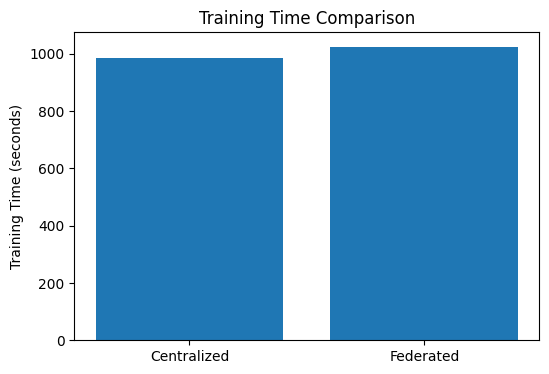

In [ ]:
plt.figure(figsize=(6, 4))

# Compare training times
plt.bar(['Centralized', 'Federated'], [centralized_training_time, federated_training_time])
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.show()


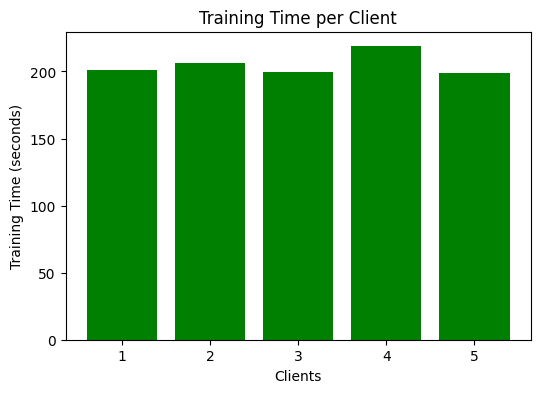

In [ ]:
plt.figure(figsize=(6, 4))

# Client-specific training times
plt.bar(range(1, len(client_times)+1), client_times, color='green')
plt.xlabel('Clients')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time per Client')
plt.show()


#### Step 5: Summary Table
Generate a table summarizing performance metrics:

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Ensure classification report outputs dictionaries
central_report = classification_report(
    recons_df['y_true'],
    recons_df['y_pred'],
    output_dict=True
)

federated_report = classification_report(
    federated_df['y_true'],
    federated_df['y_pred'],
    output_dict=True
)

# Safeguard against missing keys
central_accuracy = central_report.get('accuracy', 0)
central_recall = central_report.get('macro avg', {}).get('recall', 0)
central_precision = central_report.get('macro avg', {}).get('precision', 0)

federated_accuracy = federated_report.get('accuracy', 0)
federated_recall = federated_report.get('macro avg', {}).get('recall', 0)
federated_precision = federated_report.get('macro avg', {}).get('precision', 0)

# Collect metrics
metrics = {
    'Model': ['Centralized', 'Federated'],
    'MAE': [np.mean(recons_df['error']), np.mean(federated_df['error'])],
    'Accuracy': [central_accuracy, federated_accuracy],
    'Recall': [central_recall, federated_recall],
    'Precision': [central_precision, federated_precision],
    'Training Time (s)': [centralized_training_time, federated_training_time]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

# Print the table in a readable format
print(tabulate(metrics_df, headers='keys', tablefmt='grid'))

# Save to CSV
metrics_df.to_csv('model_comparisons.csv', index=False)


+----+-------------+----------+------------+----------+-------------+---------------------+
|    | Model       |      MAE |   Accuracy |   Recall |   Precision |   Training Time (s) |
+====+=============+==========+============+==========+=============+=====================+
|  0 | Centralized | 0.169203 |    0.81066 | 0.853159 |    0.646269 |             985.192 |
+----+-------------+----------+------------+----------+-------------+---------------------+
|  1 | Federated   | 0.431836 |    0.87873 | 0.781875 |    0.676171 |            1024.23  |
+----+-------------+----------+------------+----------+-------------+---------------------+


<div class="alert alert-success" role="alert">
<h1>Conclusion</h1>
<p>In conclusion, anomaly detection is a critical task in many fields, including finance, healthcare, and cybersecurity. Autoencoders have emerged as a powerful tool for anomaly detection due to their ability to learn compressed representations of data and generate accurate reconstructions of the original input. By training an autoencoder on normal data and using it to reconstruct new data points, anomalies can be identified based on the magnitude of their reconstruction error. However, choosing the right threshold for the reconstruction error is crucial to balance the tradeoff between detecting anomalies and generating false positives. Overall, autoencoders provide a promising approach for anomaly detection that can be applied to a wide range of domains and applications.</p>   
